# ECE 227: Big Data
### Group 8: Multi-Layer/ Multi-Plex graphs with OpenStreetMaps


In [1]:
#Library Dependancies to be installed to run OpenStreetMaps dynamically:
!pip install osmnx
!pip install -U osmnx

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Attempt speedup by installing a GPU-using-backend for networkX:
#!python -m pip install nx-cugraph-cu11 --extra-index-url https://pypi.nvidia.com
#!NX_CUGRAPH_AUTOCONFIG=True jupyter-notebook G8_Project.ipynb
#import nx_cugraph as nxcg


#### Import libraries for Python usage: most use as sub-dependancies to OSMnx

In [3]:
import osmnx as ox
import networkx as nx
import io
import matplotlib
import scipy as sp
import sklearn
import random

In [4]:
#script from stackexchange reappropriated for our total calculations:
def calc_length_time(route_graph, route):
    '''Input: Graph, Route
       Returns: total length, total travel time of given route
    '''
    route_length_exp = route_travel_time_exp = 0
    for u, v in zip(route, route[1:]):  
      edge_length = route_graph.get_edge_data(u,v)[0]['length']   # Returns length in meters, e.g. 50.26
      route_length_exp += edge_length
      edge_travel_time = route_graph.get_edge_data(u,v)[0]['travel_time'] # Returns travel time in secs
      route_travel_time_exp += edge_travel_time
    return route_length_exp, route_travel_time_exp



#### __Verifications__:
First, we want to test/verify how to select some endpoints (nodes) to test our usage of our graph as a map. 

The OSMnx library uses web-API calls to various cloud services, with geocoding referencing the 'Nominatim' API to associate places to (latitude,longitude) coordinates. 

We use these coordinates to reference our nodes in the graph/map.

For our test cases, we want to limit a smaller focal-map and framiliar routes, so we have chosen to map around UCSD with a bounding box extended of +-5000 km. 

For our endpoints to demonstrate, we decided to use Geisel Library and a local restraunt to UTC as 'Chicago Fire & Grill'.

Graph from: UCSD (32.8792438, -117.2311247)
Peterson_Hall (lat,long):  (32.880001, -117.24031)
Focal Point:  (32.8792438, -117.2311247)
plot of driving layer: 


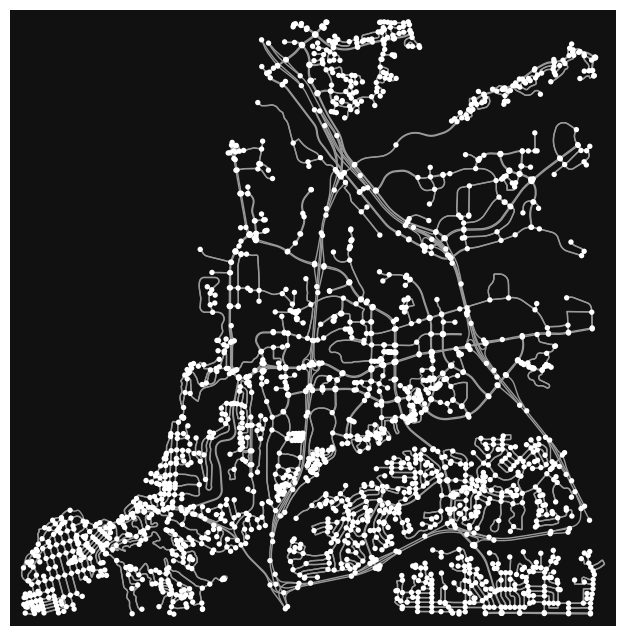

plot of walking layer: 


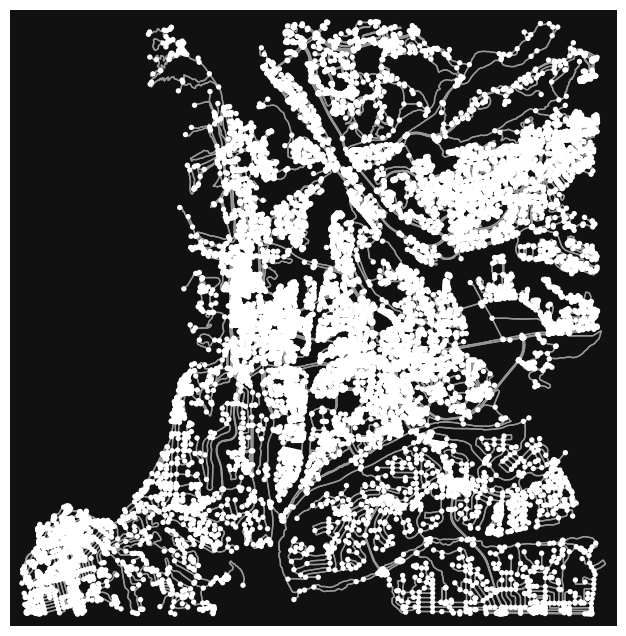

In [7]:

# Ref: OSMnx getting started page:
# Internal function API-reference to download/model a street network for some city then visualize it: 
# *note: osmnx depends on webAPI function calls, so allowing web-connected context is fine for a demonstration.

# Set our graphs parameter network_type to "drive".
#ox.settings.bidirectional_network_types += "drive"

# Apparently, proper geocoding is the hard part of the natural/API functions...
#print("Graph from: La Jolla",                 ox.geocoder.geocode("La Jolla"))
#print("Chicago Fire & Grill @ ", ox.geocoder.geocode("Chicago Fire & Grill"))
print("Graph from: UCSD",                     ox.geocoder.geocode("UCSD"))
#print("Graph from: San Diego",                    ox.geocoder.geocode("San Diego"))
#print("Graph from: La Jolla",                 ox.geocoder.geocode("La Jolla"))

# Some points are not held in Nominatim's geocode-library via webAPI call, but can be found on the map itself:
Peterson_Hall = (32.880001,-117.24031)
print("Peterson_Hall (lat,long): ", Peterson_Hall)
focal_point = ox.geocoder.geocode("UCSD")
print("Focal Point: ",focal_point)

# Here, we are declaring our graph to be mapped around a bounding box of 5000 km around our location (UCSD):
G_drive = ox.graph.graph_from_point(focal_point, 5000, dist_type='bbox', network_type='drive')
#G_drive = ox.graph.graph_from_place("San Diego, California, USA", network_type="drive")
print("plot of driving layer: ")
fig, ax = ox.plot.plot_graph(G_drive, save=True, filepath="./data/G_drive.png")

G_walk = ox.graph.graph_from_point(focal_point, 5000, dist_type='bbox', network_type='walk')
#G_walk = ox.graph.graph_from_place("San Diego, California, USA", network_type="walk")
print("plot of walking layer: ")
fig, ax = ox.plot.plot_graph(G_walk, save=True, filepath="./data/G_walk.png")


#Attempt to use our GPU backend for our graphs:
#G_drive = nxcg.from_networkx(G_drive)
#G_walk  = nxcg.from_networkx(G_walk)

# convert your MultiDiGraph to an undirected MultiGraph -- 
# *note: some points are declared directed as one-way streets inappropriately, attempts in other expressions were made.
#M = ox.convert.to_undirected(G)
#fig, ax = ox.plot.plot_graph(M)
#fig, ax = ox.plot.plot_graph(ox.convert.to_undirected(G_drive))
#fig, ax = ox.plot.plot_graph(ox.convert.to_undirected(G_walk))

In [8]:
# Converting the graph to node & edge GeoPandas GeoDataFrames for data tabulation:

gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_walk)

#print(gdf_edges[:10])
# .head() does what? :: displays first few samples*

# *note: can Convert node/edge GeoPandas GeoDataFrames back to a NetworkX MultiDiGraph after edits/augments:
#print("graph from node/edges: /n")
#Gdf_model = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)
#fig, ax = ox.plot.plot_graph(Gdf_model)

#### Geocoding references for points in our area:

an important note: each of our nodes here are an area* rather than a point. 

Some areas are large enough for their own internal maps, but have a geometric central location point.

This is a practical implementation for a real-data problem, but has its own pros & cons, like having more complexity.

In [9]:
# Testing Geocode points available - get some sample start/finish points:

print("Southern California: \t",ox.geocoder.geocode("Southern California"))
print("San Diego: \t\t",          ox.geocoder.geocode("San Diego"))
print("La Jolla: \t\t",           ox.geocoder.geocode("La Jolla"))
print("UCSD: \t\t\t",                 ox.geocoder.geocode("UCSD"))
print("Chicago Fire & Grill: \t", ox.geocoder.geocode("Chicago Fire & Grill"))
print("Geisel Library: \t",       ox.geocoder.geocode("Geisel Library"))
print("Peterson Hall - manual coords from Nominatim's map GUI: ",        Peterson_Hall)

Southern California: 	 (34.169263, -116.7874482)
San Diego: 		 (32.7174202, -117.162772)
La Jolla: 		 (32.8401623, -117.2740777)
UCSD: 			 (32.8792438, -117.2311247)
Chicago Fire & Grill: 	 (32.8677581, -117.2061138)
Geisel Library: 	 (32.8811393, -117.2375798)
Peterson Hall - manual coords from Nominatim's map GUI:  (32.880001, -117.24031)


#### Verify Attributes in our data's nodes:

In [10]:
print(gdf_nodes.head())
#print(gdf_nodes.tail())

                  y           x  street_count highway junction railway  \
osmid                                                                    
48857728  32.888599 -117.207626             3     NaN      NaN     NaN   
48857730  32.889621 -117.209044             3     NaN      NaN     NaN   
48860245  32.857104 -117.185157             3     NaN      NaN     NaN   
48871228  32.863137 -117.224795             4     NaN      NaN     NaN   
48871229  32.863194 -117.225151             1     NaN      NaN     NaN   

                             geometry  
osmid                                  
48857728   POINT (-117.20763 32.8886)  
48857730  POINT (-117.20904 32.88962)  
48860245   POINT (-117.18516 32.8571)  
48871228  POINT (-117.22479 32.86314)  
48871229  POINT (-117.22515 32.86319)  


In [11]:
#### Verify Attributes in our data's edges:

In [12]:
print(gdf_edges.head())
#print(gdf_edges.tail())

                             osmid  highway  oneway reversed      length  \
u        v           key                                                   
48857728 793207130   0     5938377  service   False    False  100.844925   
         793206996   0    64512417  service   False    False   20.157423   
         793207551   0     5938377  service   False     True   78.511897   
48857730 6987382627  0     5938377  service   False    False   12.329706   
         11508711737 0     5938377  service   False     True   29.951200   

                                                                   geometry  \
u        v           key                                                      
48857728 793207130   0    LINESTRING (-117.20763 32.8886, -117.20843 32....   
         793206996   0    LINESTRING (-117.20763 32.8886, -117.20769 32....   
         793207551   0    LINESTRING (-117.20763 32.8886, -117.20747 32....   
48857730 6987382627  0    LINESTRING (-117.20904 32.88962, -117.20915 32

#### Observations directly from observations of the dataset attributes:

We will be experiencing a lot of partial/empty data points per attribute - which is a realistic problem in real-time data collected from many different sources.

In [13]:
# Many attempts at modifying/editing, operating over the data-frame data used...
# While usable, we are opting to try not to reconstruct our map multiple times 
# & minimize possible distortions to from the raw data...

#import geopandas as gpd
# fetch the crs from multidigraph
#crs = G_drive.graph["crs"]

# check whether the crs is projected
#gpd.GeoSeries(crs=crs).crs.is_projected

## Pre-Computing for Our functions:

In [14]:
# *** Pre-computing: Adding/augmenting edge attributes for our calculations:

# One big problem is inferred speeds when nodes/edges are empty: 
# - one good method is to define a dictionary for known attributes to associate speeds in local road_types.

#Dictionary to reference various speeds w/ common OSM tags (in km/h):
#road_type_speeds = {
#    'motorway': 104.6,       # highway
#    'trunk': 104.6,          # major roads
#    'primary': 72.4,         # main streets
#    'secondary': 72.4,
#    'tertiary': 72.4,
#    'residential': 32.2,     # residential
#    'living_street': 32.2,
    # add more types as needed
#}

#Apply our dictionary of speeds to our graph's edges:
#for u, v, data in G_drive.edges(data=True):
#    #Process: 'highway' tag may be a list or string
#    highway_tags = data.get('highway', [])
#    if isinstance(highway_tags, str):
##        highway_tags = [highway_tags]
#
#    # Find the primary highway type for this edge, map to our dict
#    if highway_tags:
#        road_type = highway_tags[0]
#    else:
#        # Default to 'residential' if no data
#        road_type = 'residential'

#    # Map to speed, default to residential speed of 32.2 kph
#    data['speed_kph'] = road_type_speeds.get(road_type, 32.2)

# Afterwards, this altered dataframes could be recompiled into a new version of our graph.

#### More usage of Internal OSMnx library function calls:

In [15]:
# conversion: 65 MPH * 1.60934 KPH/MPH ≈ 104.6 kph
# Ref: Stack Exchange snippet:, default calculations should be in kph
    # Add travel times and speed to the edges of the graph: def: kph?
#nx.set_edge_attributes(G_drive, name="speed_kph")
#G_drive = ox.add_edge_speeds(G_drive, hwy_speeds=104, fallback=50)
#G_drive = ox.routing.add_edge_speeds(G_drive, hwy_speeds=road_type_speeds, fallback=32.2)

# Here, we tell the graph to implicitely calculate speeds based on attributes. -> & use those for travel time
G_drive = ox.routing.add_edge_speeds(G_drive)
G_drive = ox.routing.add_edge_travel_times(G_drive)


Implicit calculations for driving graph in distance -> speeds -> travel_times is the base use case for OSMnx, so the internal functions are straightforward for these tasks.

For the walking graph this is not so clear, as road_type speeds attributed to walking pathways are imputed as walking speeds since most sidewalks are also shared by road edges.

We eventually determined to resolve this problem by setting all pathway types to the average walking speed instead, due to limited time and complexity. 

_*note: Ideally, we would similarly to above use a dictionary per pathway type and reference other graph attributes such as elevation, traffic, or crossings to deviate different walking speeds for the route._

A consequence to a flat speed for all walking-routes is that our metric for the shortest-path for length will also end up being the same shortest path for time-travelled, for all nodes and edges under these conditions.

In [16]:
# Manually set every walking path speed to 4 kph (avg walking speed) (~1.1 m/s):

#nx.set_edge_attributes(G, values=5, name="speed_kph")
nx.set_edge_attributes(G_walk, values=4.0, name="speed_kph")
#G_walk = ox.add_edge_speeds(G_walk, hwy_speeds=4.0, fallback=4.0)
G_walk = ox.add_edge_travel_times(G_walk)

Verification for our edge attributes following our changes:

*note: we tried to use as many internal function calls as we could manage instead of hardcoding solutions, but all existing impute declarations only partially set walking-speeds, leaving the remainder as driving-speeds, so we had to hard-overwrite all walking graph edges to walking speed (4 km/h: ~1.1 m/s).

In [17]:
# see mean speed/time values by road type:

#edges = ox.convert.graph_to_gdfs(G_drive, nodes=False)
#edges["highway"] = edges["highway"].astype(str)
#edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

edges = ox.convert.graph_to_gdfs(G_walk, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)


length  speed_kph  travel_time
highway                                                          
['corridor', 'footway']              35.3        4.0         31.8
['footway', 'path', 'pedestrian']   211.2        4.0        190.0
['footway', 'path']                 289.7        4.0        260.8
['footway', 'pedestrian']            62.2        4.0         56.0
['footway', 'residential']          176.3        4.0        158.7
...                                   ...        ...          ...
steps                                11.5        4.0         10.3
tertiary                             83.1        4.0         74.8
tertiary_link                        51.0        4.0         45.9
track                               155.6        4.0        140.1
unclassified                         55.5        4.0         50.0

[65 rows x 3 columns]

#### __Task to demonstrate the Graph/Map:__ 

A driving/walking route, per each different graph-layer type:
we solve this task with a shortest-distance calculation to define our route.

Our route: an iterable of nodes to traverse.

We can use different weights to demonstrate importance of different nodes/edges per priority. This is most intuitive in the context of a route's shortest total distance vs shortest total travel-time.

So for our selected route: "Geisel Library" in UCSD to a local restraunt in UTC "Chicago Fire & Grill": we can calculate a driving graph for shortest length, shortest time-traveled, as well as the same for a walking graph (which is currently the same route for time and distance metrics):

In [18]:
# Utility Question: 
# Pick a 'starting', 'ending' destination nodes in our graph to demonstrate:

# ***NOTE: geocode returns (lat,long), but nearest_node takes (long,lat)
drive_starting_point = ox.distance.nearest_nodes(G_drive, *ox.geocoder.geocode("Geisel Library")[::-1], return_dist=True)
drive_end_point = ox.distance.nearest_nodes(G_drive, *ox.geocoder.geocode("Chicago Fire & Grill")[::-1], return_dist=True)

# and for walk-graph:
walk_starting_point = ox.distance.nearest_nodes(G_walk, *ox.geocoder.geocode("Geisel Library")[::-1], return_dist=True)
walk_end_point = ox.distance.nearest_nodes(G_walk, *ox.geocoder.geocode("Chicago Fire & Grill")[::-1], return_dist=True)

# *note: with distance differences from the declared gps point.(*:? verify specifics.)
print("starting point (node id#): drive:\t", drive_starting_point)
print("starting point (node id#): walk:\t", walk_starting_point)
print("end point (node id#): drive:\t", drive_end_point)
print("end point (node id#): walk:\t", walk_end_point)


# Resolve shortest Path based on different weights:
drive_route1 = ox.routing.shortest_path(G_drive, drive_starting_point[0], drive_end_point[0], weight='length', cpus=1)
drive_route2 = ox.routing.shortest_path(G_drive, drive_starting_point[0], drive_end_point[0], weight='travel_time', cpus=1)

walk_route1 = ox.routing.shortest_path(G_walk, walk_starting_point[0], walk_end_point[0], weight='length', cpus=1)
walk_route2 = ox.routing.shortest_path(G_walk, walk_starting_point[0], walk_end_point[0], weight='travel_time', cpus=1)


# Add different weights, (eg: custom weights w/ multiple layers)*** here if time
#print("drive_route1: ", drive_route1)

starting point (node id#): drive:	 (4554611506, 121.38918311061502)
starting point (node id#): walk:	 (12316437964, 19.345096087357)
end point (node id#): drive:	 (658986103, 102.18963047325136)
end point (node id#): walk:	 (1429439655, 22.705947829018218)


Internal function calls are available but limited in context and execution:
For example, shortest-distance-length is used to return values only for the weight-optimized measurement, and not the consequential effect (if optimizing for length, we don't get the travel_time.)

So we use a function to calculate both the manual/brute force way.

In [19]:

#travel_time could be made more accurate with some kind of intersection delay data & traffic - otherwise good.
drive_route_travel_time = nx.shortest_path_length(G_drive, drive_starting_point[0], drive_end_point[0], weight='travel_time')
drive_route_length = nx.shortest_path_length(G_drive, drive_starting_point[0], drive_end_point[0], weight='length') 
print("driving length: ", drive_route_length, " meters.")
print("driving travel_time: ", drive_route_travel_time, " seconds.")

#walking is not calculating properly... length seems to check due to diff datapoints.
walk_route_travel_time = nx.shortest_path_length(G_walk, walk_starting_point[0], walk_end_point[0], weight='travel_time')
walk_route_length = nx.shortest_path_length(G_walk, walk_starting_point[0], walk_end_point[0], weight='length') 
print("walking length: ", walk_route_length, " meters.")
print("walking travel_time: ", walk_route_travel_time, " seconds.")
print("The internal dataset function calls are limited to only calculating the path optimized.")

# This calculate length function still important, because it allows both length/time per all routes:
drive_shortest_distance = calc_length_time(G_drive,drive_route1)
drive_shortest_time = calc_length_time(G_drive,drive_route2)
walk_shortest_distance = calc_length_time(G_walk,walk_route1)
walk_shortest_time = calc_length_time(G_walk,walk_route2)


# proposed_route is as a list of routes by different weight type
drive_proposed_route = [drive_route1, drive_route2]
walk_proposed_route  = [walk_route1,  walk_route2]

# Sanity checks: each route is a list of iterables (nodes):
#print("proposed driving route: ", drive_proposed_route)
#print("proposed walking route: ", walk_proposed_route)

# Here we practice using a color-randomized assignment per different routes, (but some colors are just bad here).
#route_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(proposed_route))]
#ox.plot.plot_graph_routes(G_drive, proposed_route, route_colors=route_colors, save=True, filepath="data/route_plot.png")


driving length:  4823.572610427192  meters.
driving travel_time:  321.88154875640237  seconds.
walking length:  4659.074116532434  meters.
walking travel_time:  4193.166704879193  seconds.
The internal dataset function calls are limited to only calculating the path optimized.


### Mapping our Shortest Path Routes:

For each graph: Drive and Walk, we are designating:

Red: as our shortest-distance path.

Blue: as our shortest-Travel time path.

Purple: Blue + Red projection for overlapped path.


note that for map traversal, we will often observe a lot of overlap for optimized routes.

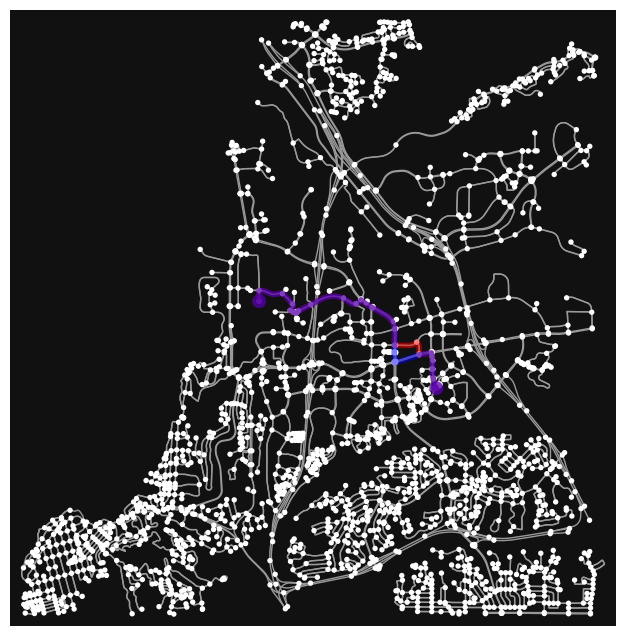

Driving-Graph Legend: 
		 Red: 	Shortest distance 
		 Blue: 	Shortest travel time


In [20]:
#Graph the Driving routes & Legend:

ox.plot.plot_graph_routes(G_drive, drive_proposed_route, route_colors=['r','b'], save=True, filepath="data/drive_route_plot.png")
print("Driving-Graph Legend: \n\t\t Red: \tShortest distance \n\t\t Blue: \tShortest travel time")


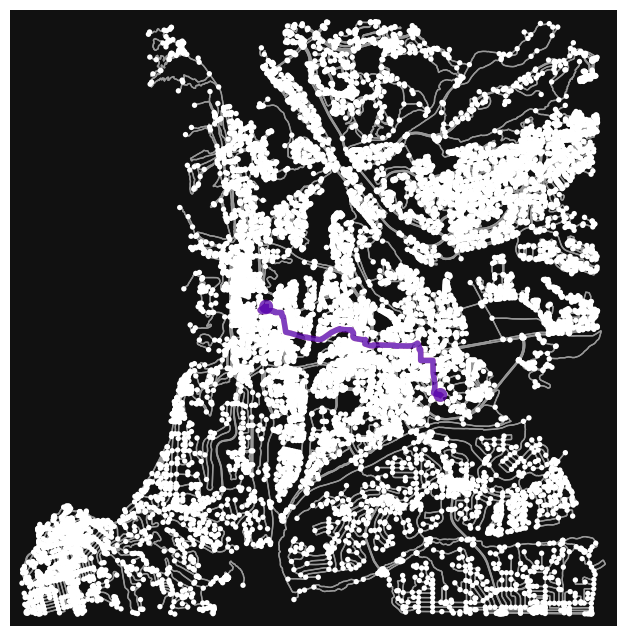

Walking-Graph Legend: 
		 Red: 	Shortest distance 
		 Blue: 	Shortest travel time
Again, note that given our setting all pedestrian walkable-spaces as the same speed to avoid incorrect data contamination, we see that shortest distance = shortest time routes.


In [21]:
#Graph the Walking routes:
ox.plot.plot_graph_routes(G_walk, walk_proposed_route, route_colors=['r','b'], save=True, filepath="data/walk_route_plot.png")
print("Walking-Graph Legend: \n\t\t Red: \tShortest distance \n\t\t Blue: \tShortest travel time")
print("Again, note that given our setting all pedestrian walkable-spaces as the same speed to avoid incorrect data contamination, we see that shortest distance = shortest time routes.")

#### Some stats for our given graphs:

Thankfully, we have an easy way to reference many of our basic statistics per graph, and even better: we can define a specific subset of the graph (a sub-area within the graph - eg: a community) to display statistics to observe divergent characteristics.

In [24]:
# what sized area does our network cover in square meters?
# Lets define an area* to which we want to observe some graph statistics for: our UCSD graphs themselves:

#Gd_proj = ox.projection.project_graph(G_drive)
d_nodes_proj = ox.convert.graph_to_gdfs(ox.projection.project_graph(G_drive), edges=False)
d_graph_area_m = d_nodes_proj.union_all().convex_hull.area


# show some basic stats about the Street-Network:
ox.stats.basic_stats(G_drive, area=d_graph_area_m, clean_int_tol=15)
# Interesting note: streets_per_node_#: most common nodes have 3* streets per node. 
# This seems unintuitive if nodes are intersections: This is likely due to nodes being geometric areas.


/home/ssharp/.local/lib/python3.11/site-packages/osmnx/simplification.py:596: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
/home/ssharp/.local/lib/python3.11/site-packages/osmnx/simplification.py:560: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


{'n': 2279,
 'm': 5179,
 'k_avg': 4.544975866608161,
 'edge_length_total': 839207.3339024619,
 'edge_length_avg': 162.04041975332342,
 'streets_per_node_avg': 2.79859587538394,
 'streets_per_node_counts': {0: 0, 1: 495, 2: 33, 3: 1213, 4: 512, 5: 26},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.21720052654673103,
  2: 0.014480035103115402,
  3: 0.5322509872751207,
  4: 0.22465993856954805,
  5: 0.011408512505484861},
 'intersection_count': 1784,
 'street_length_total': 549153.8777483852,
 'street_segment_count': 3166,
 'street_length_avg': 173.45353055855503,
 'circuity_avg': 1.0779787146364384,
 'self_loop_proportion': 0.00410612760581175,
 'clean_intersection_count': 1,
 'node_density_km': 29.879417615206233,
 'intersection_density_km': 23.389592376273768,
 'edge_density_km': 11002.644315671558,
 'street_density_km': 7199.82362801839,
 'clean_intersection_density_km': 0.013110758058449423}

In [25]:
w_nodes_proj = ox.convert.graph_to_gdfs(ox.projection.project_graph(G_walk), edges=False)
w_graph_area_m = w_nodes_proj.union_all().convex_hull.area


# show some basic stats about the Street-Network:
ox.stats.basic_stats(G_walk, area=w_graph_area_m, clean_int_tol=15)

/home/ssharp/.local/lib/python3.11/site-packages/osmnx/simplification.py:596: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
/home/ssharp/.local/lib/python3.11/site-packages/osmnx/simplification.py:560: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


{'n': 15693,
 'm': 42532,
 'k_avg': 5.4205059580704775,
 'edge_length_total': 2484216.866460456,
 'edge_length_avg': 58.40818363727208,
 'streets_per_node_avg': 2.7182183138979163,
 'streets_per_node_counts': {0: 0,
  1: 3593,
  2: 0,
  3: 9401,
  4: 2637,
  5: 60,
  6: 1,
  7: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2289555852928057,
  2: 0.0,
  3: 0.599056904352259,
  4: 0.16803670426304723,
  5: 0.003823360734085261,
  6: 6.372267890142101e-05,
  7: 6.372267890142101e-05},
 'intersection_count': 12100,
 'street_length_total': 1242108.433230225,
 'street_segment_count': 21266,
 'street_length_avg': 58.40818363727194,
 'circuity_avg': 1.129444639908188,
 'self_loop_proportion': 0.005783880372425468,
 'clean_intersection_count': 1,
 'node_density_km': 181.97192324905095,
 'intersection_density_km': 140.30843505470696,
 'edge_density_km': 28806.3289974855,
 'street_density_km': 14403.164498742715,
 'clean_intersection_density_km': 0.011595738434273304}

#### Interesting Observations given the statistics:

streets_per_node_#: The most common nodes have 3* streets per node in both graphs.
This seems unintuitive if nodes are intersections: This is likely due to nodes being geometric areas, and a downstream consequence of how the data was compiled: likely merging of direct scrapping of other maps to translate datapoints around map-oriented geometric areas on the maps themselves. 

This would indicate that almost all geometries that define nodes were created due to their seperation via edges on multiple sides, with exceptions/context/nuance to otherwise clear boundary cases.

Also interesting is that our walking graph has 0x '2-streets per node' nodes, which would be a base intuition of sets of 2 as 'throughway paths'.

This is likely the same explanation as above, a consequence of how the data is collected and labeled as relative geometric areas. 

A likely case is that the nodes in the walking graph are specifically at intersecting points that specifically deviate from a continuous throughway. If the data was based on GPS coordinates collected, they would have been filtered out as an otherwise near-infinate continuous space of nodes (or a pipe geometry?) - which would be complicated to model appropriately in the data.

Since the data was collected via the same sources and mechanisms, (likely the bulk of it referencing the same street points) - it is unsuprising that much of the statistical trends are effectively shared between the walk and drive graph data.

In [26]:
# To save our graphs as file:

# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.io.save_graph_geopackage(G_drive, filepath="./data/G_drive.gpkg")
ox.io.save_graphml(G_drive, filepath="./data/G_drive.graphml")

ox.io.save_graph_geopackage(G_walk, filepath="./data/G_walk.gpkg")
ox.io.save_graphml(G_walk, filepath="./data/G_walk.graphml")

In [27]:
# Load graph as file: (.graphml seems to be the graph-oriented data structure? for networkx?)
# we'll build this when its needed
#print("checkpoint!")

#### Task: Lets relate our edges via: closeness_centrality

How to do at the scale of a larger graph? A heatmap!
Here, we have realized that for a graph-map, it is the edges that bear the importance and can be mapped visually.
So we calculate our centrality metrics over our edges via: swapping them using nx.line_graph(G).

In [28]:
# convert graph to line graph so edges become nodes and vice versa
# Block of code: networkX function to:
# 1) calculate closeness_centrality 
# 2) create schema by apply cmap based on centrality
# 3) plot schema over the original graph
# --> heatmap of >closeness_centrality< !!!

#ref: nx.betweenness_centrality(cit_patents_graph, k=k, backend="cugraph")
D_G_edge = nx.line_graph(G_drive)
#d_edge_centrality = nx.closeness_centrality(D_G_edge, backend="cugraph")
d_edge_centrality = nx.closeness_centrality(D_G_edge)
nx.set_edge_attributes(G_drive, d_edge_centrality, "edge_closeness_centrality")
#nx.set_edge_attributes(G_drive, nx.closeness_centrality(nx.line_graph(G_drive)), "edge_centrality")

W_G_edge = nx.line_graph(G_walk)
#w_edge_centrality = nx.closeness_centrality(W_G_edge, backend="cugraph")
w_edge_centrality = nx.closeness_centrality(W_G_edge)
nx.set_edge_attributes(G_walk, w_edge_centrality, "edge_closeness_centrality")
#nx.set_edge_attributes(G_walk, nx.closeness_centrality(nx.line_graph(G_walk)), "edge_centrality")
# fig, ax = ox.plot.plot_graph(G, edge_color=edge_centrality, edge_linewidth=2, node_size=0)

#note: this takes a while, with networkX calculations for relative calculations...

In [ ]:
#ox.save_load.save_as_osm(G, 'SD_road_closeness.osm')
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_cc.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_cc.graphml')



In [ ]:
#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_cc.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_cc.graphml')


In [32]:
print("checkpoint achieved! \n Centrality Calculations take a lot of computation.")
#D_G_edge = nx.line_graph(G_drive)
#W_G_edge = nx.line_graph(G_walk)
#print(d_edge_centrality)

checkpoint achieved! 
 Centrality Calculations take a lot of computation.


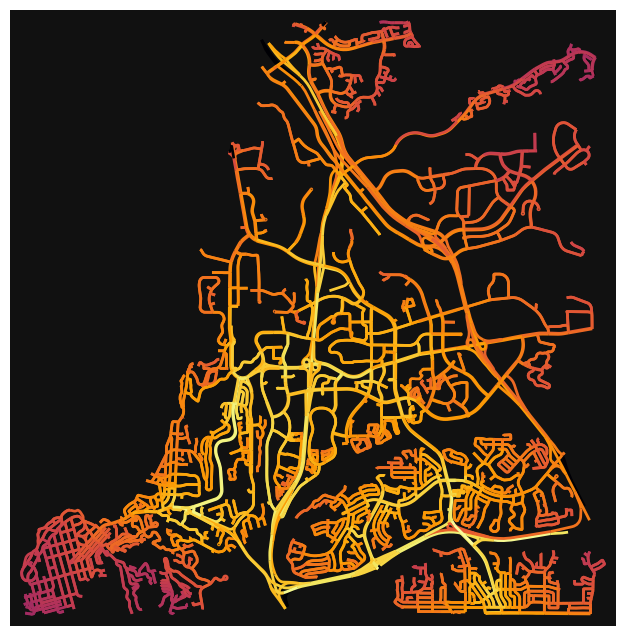

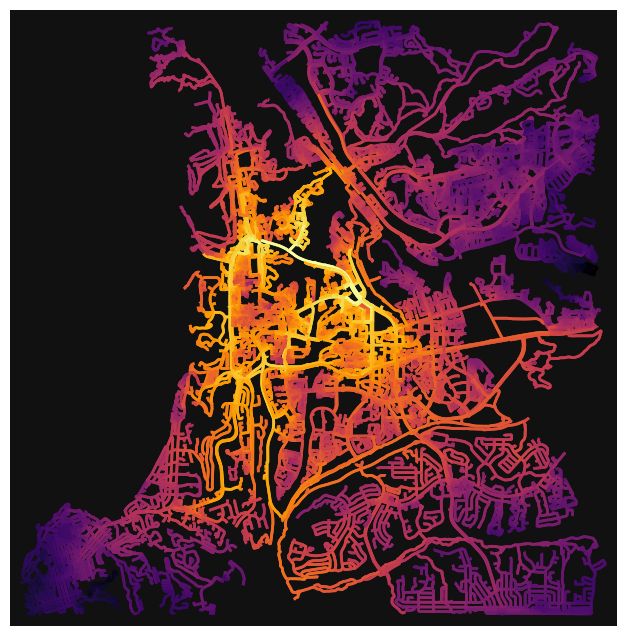

In [33]:
# color edges in original graph with closeness centralities from line graph
# plot graph-map: apply heatmap 'inferno'

# Overlay color scheme to scale by centrality w/ cmap: inferno (heatmap)
d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_closeness_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_closeness_d_UCSD.png")

#fig, ax = ox.plot.plot_graph(G, edge_color=e_close_cent, edge_linewidth=2, node_size=0)
w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_closeness_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_closeness_w_UCSD.png")



### Observations of our Heatmaps for Edge-Closeness-Centrality:

Here, the maps themselves are more intuitive than expected: 

#### The driving graph:
This is showing us that for our Driving-graph of the area around greater UCSD/La Jolla, our most central edges are the areas around the Freeways - which is what they are literally designed and function to do. Outside of the relative centrality, they do remain high throughout the majority of the map, which indicate that the roads all hold high degree of centrality - holding good connectivity with each other (again: their function).

We would get more differentiations if our map was extended farther away from our focal point and included other diverging areas, but this remains intuitive. The endpoints at the coast and edges of the map (removed from other social context/data points) are cut off and show as isolated areas of this bounded-box graph, which does distort the larger picture analysis in assuming they arent* central or important overall (--just in the context of the bounded map).

#### The walking graph:
This map is more informative of the structure of our walkability around UCSD: Internal to the region that is UCSD itself, there is high intensity for closeness centrality for walkable paths. 
This also shows the design priority for walkable paths within UCSD, and by extention the campus housing and UTC Mall - as well as demonstrating the lack of priority in the general city area that is not created for walkability. 
This difference is much more easily observed here with our closeness centrality calculation than can be observed on a general map.

Another observation is that while the path along the I-5 freeway is adequately devoid of walkability on the walking-graph, the same isn't necessarily true for the highway-52. 
I suspect there may have been overlap in the data collection which was then filtered out with roadways of high-intensity traffic (primary freeways), but may have missed the smaller, more locallized highways (52). 
It is also possible that there is another explanation, and that a hidden walkable route exists alongside the 52 that could be investigated as followup for this observation.



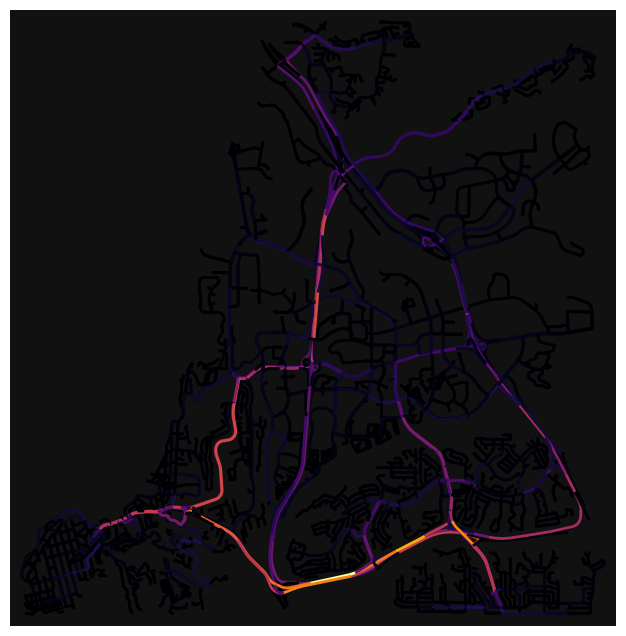

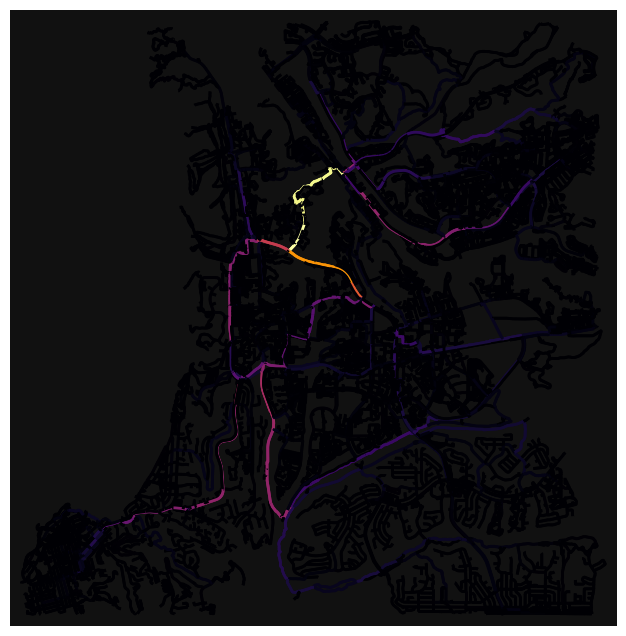

In [36]:
# Now lets try some other metrics:
# Betweenness Centrality
# Eigenvector Centrality
# Load Centrality
# Current-Flow-Centrality

# D_G_edge = nx.line_graph(G_drive)
# W_G_edge

# Since betweenness is so computationally intensive, that we simply cant seem to finish it before our VM shuts off:
# We will set k to some arbitrarily large, but <#n number to 'approximate' our values. 
# Since our nodes are 5500< and edges even more, lets say ~600.

# Betweenness Centrality: mapping our traffic-bottlenecks and critical paths:
#d_edge_betw_centrality = nx.betweenness_centrality(D_G_edge, k=600)
d_edge_betw_centrality = nx.betweenness_centrality(D_G_edge)
nx.set_edge_attributes(G_drive, d_edge_betw_centrality, "edge_betweenness_centrality")
#w_edge_betw_centrality = nx.betweenness_centrality(W_G_edge, k=600)
w_edge_betw_centrality = nx.betweenness_centrality(W_G_edge)
nx.set_edge_attributes(G_walk, w_edge_betw_centrality, "edge_betweenness_centrality")

# Plot our between_ness centrality hotmap:
d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_betweenness_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_betweenness_d_UCSD.png")
w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_betweenness_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_betweenness_w_UCSD.png")


In [37]:
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_bc.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_bc.graphml')

#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_bc.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_bc.graphml')


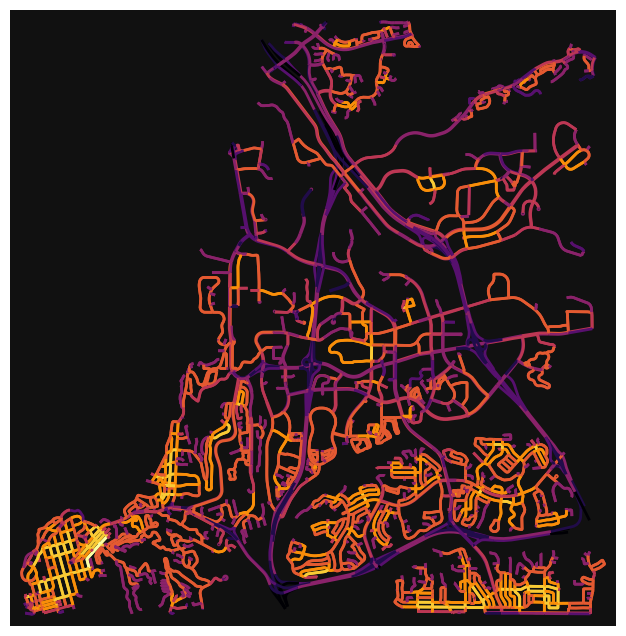

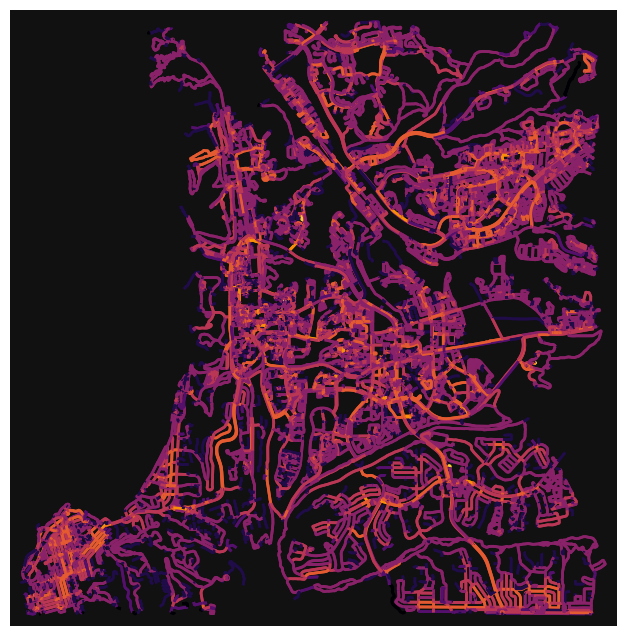

In [38]:

# Degree Centrality: Our degree Centrality may be boring, but we can see what pops out:
#d_edge_deg_centrality = nx.degree_centrality(D_G_edge, backend="cugraph")
d_edge_deg_centrality = nx.degree_centrality(D_G_edge)
nx.set_edge_attributes(G_drive, d_edge_deg_centrality, "edge_degree_centrality")
#w_edge_deg_centrality = nx.degree_centrality(W_G_edge, backend="cugraph")
w_edge_deg_centrality = nx.degree_centrality(W_G_edge)
nx.set_edge_attributes(G_walk, w_edge_deg_centrality, "edge_degree_centrality")

# Plot our between_ness centrality hotmap:
d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_degree_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_degree_d_UCSD.png")
w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_degree_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_degree_w_UCSD.png")


In [39]:
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_dc.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_dc.graphml')

#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_dc.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_dc.graphml')

In [9]:
#G_drive = ox.load_graphml('./data/Graph_drive_UCSD_dc.graphml')
#G_walk = ox.load_graphml('./data/Graph_walk_UCSD_dc.graphml')

#D_G_edge = nx.line_graph(G_drive)
#W_G_edge = nx.line_graph(G_walk)

In [ ]:

# Eigenvector Centrality: I want to assume this form is more to do with complex dynamical relationships...
# But lets map it and see if it shows off some secrets:

# **note: It is not implemented with multi-graph for networkX at all.

#d_edge_eigen_centrality = nx.eigenvector_centrality(D_G_edge, backend="cugraph")
#d_edge_eigen_centrality = nx.eigenvector_centrality(D_G_edge)
#nx.set_edge_attributes(G_drive, d_edge_eigen_centrality, "edge_eigenvector_centrality")
#w_edge_eigen_centrality = nx.eigenvector_centrality(W_G_edge, backend="cugraph")
#w_edge_eigen_centrality = nx.eigenvector_centrality(W_G_edge)
#nx.set_edge_attributes(G_walk, w_edge_eigen_centrality, "edge_eigenvector_centrality")

# Plot our between_ness centrality hotmap:
#d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_eigenvetor_centrality", cmap="inferno")
#fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_eigenvector_d_UCSD.png")
#w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_eigenvector_centrality", cmap="inferno")
#fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_eigenvector_w_UCSD.png")


In [ ]:
#ox.save_graphml(G_drive, './data/Graph_drive_UCSD_ec.graphml')
#ox.save_graphml(G_walk, './data/Graph_walk_UCSD_ec.graphml')

#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_ec.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_ec.graphml')


#### Our Eigenvector Centrality is graph-type dependent and not programmed to handle Multi-Graphs*, which is our map-graph structure. So we will skip this calculation.

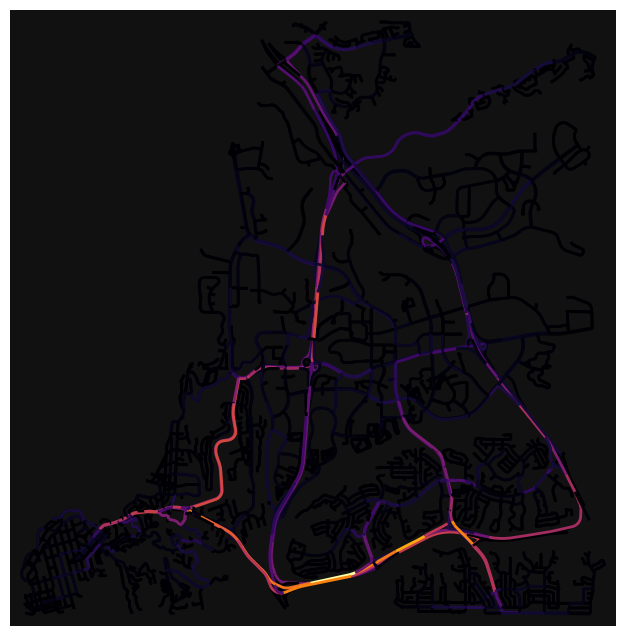

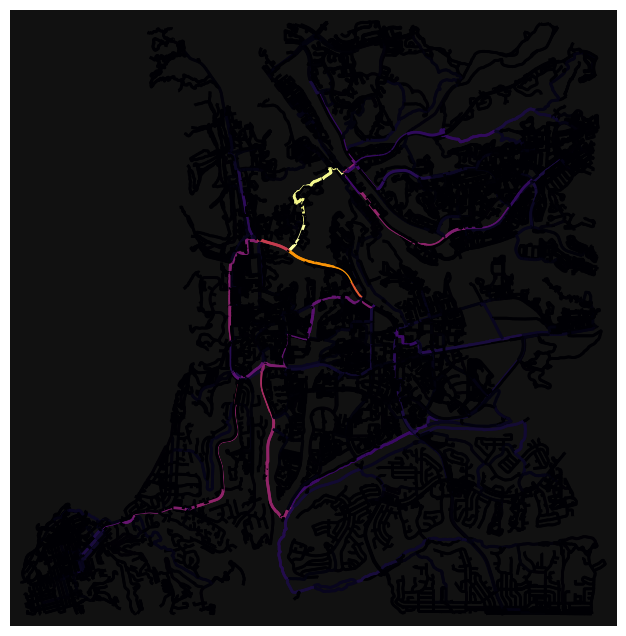

In [6]:

# Load Centrality: Load Centrality: "fraction of all shortest paths that pass through the node"
#d_edge_load_centrality = nx.load_centrality(D_G_edge, backend="cugraph")
d_edge_load_centrality = nx.load_centrality(D_G_edge)
nx.set_edge_attributes(G_drive, d_edge_load_centrality, "edge_load_centrality")
#w_edge_load_centrality = nx.load_centrality(W_G_edge, backend="cugraph")
w_edge_load_centrality = nx.load_centrality(W_G_edge)
nx.set_edge_attributes(G_walk, w_edge_load_centrality, "edge_load_centrality")

# Plot our load centrality hotmap:
d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_load_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_load_d_UCSD.png")
w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_load_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_load_w_UCSD.png")


In [7]:
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_lc.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_lc.graphml')

#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_lc.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_lc.graphml')


In [ ]:
#G_drive = ox.load_graphml('./data/Graph_drive_UCSD_lc.graphml')
#G_walk = ox.load_graphml('./data/Graph_walk_UCSD_lc.graphml')

#D_G_edge = nx.line_graph(G_drive)
#W_G_edge = nx.line_graph(G_walk)

In [8]:

# Current Flow Betweenness Centrality: Calculation for "Electrical Flow", which may be a closer approximation of potential traffic:
#d_edge_cflow_centrality = nx.current_flow_betweenness_centrality(D_G_edge, backend="cugraph")
d_edge_cflow_centrality = nx.current_flow_betweenness_centrality(D_G_edge, k=600)
nx.set_edge_attributes(G_drive, d_edge_cflow_centrality, "edge_current_flow_centrality")
#w_edge_cflow_centrality = nx.current_flow_betweenness_centrality(W_G_edge, backend="cugraph")
w_edge_cflow_centrality = nx.current_flow_betweenness_centrality(W_G_edge, k=600)
nx.set_edge_attributes(G_walk, w_edge_cflow_centrality, "edge_current_flow_centrality")

# Plot our load centrality hotmap:
d_ec = ox.plot.get_edge_colors_by_attr(G_drive, "edge_current_flow_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_drive, edge_color=d_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_current_flow_d_UCSD.png")
w_ec = ox.plot.get_edge_colors_by_attr(G_walk, "edge_current_flow_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G_walk, edge_color=w_ec, edge_linewidth=2, node_size=0, save=True, filepath="./data/edge_current_flow_w_UCSD.png")


NetworkXNotImplemented: not implemented for directed type

#### also not implemented for directed graph type

In [ ]:
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_cfc.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_cfc.graphml')

#G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_cfc.graphml')
#G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_cfc.graphml')


## Saving and Loading our graphs:

Since the closeness centrality metric takes a lot of calculations, we can mark this as a time to checkmark our progress with saving our graph and testing our loading functions to verify that our modifications are also saved.

In [ ]:
#ox.save_load.save_as_osm(G, 'SD_road_closeness.osm')
ox.save_graphml(G_drive, './data/Graph_drive_UCSD_complete.graphml')
ox.save_graphml(G_walk, './data/Graph_walk_UCSD_complete.graphml')



#### and Loading:

In [ ]:
#G2 = ox.load_graphml(G, 'SD_road_closeness.graphml')
G2_drive = ox.load_graphml('./data/Graph_drive_UCSD_complete.graphml')
G2_walk = ox.load_graphml('./data/Graph_walk_UCSD_complete.graphml')

#test loading augmentations to edges: 'edge_centrality'
#nx.get_edge_attributes(G2_drive, 'edge_centrality')[:10]

In [ ]:
print(len(nx.get_edge_attributes(G2_drive, 'edge_closeness_centrality')))

Our saving and loading of our graphs will appropriately pass our set attributes. 

In [ ]:
# Ref: stackoverflow: function calls that effectively map shortest-path between nx, ox.
#G = ox.graph_from_place(PLACE, network_type='all_private', retain_all = True, simplify=True,truncate_by_edge=False) ``` 

#w3_dict = dict((zip(zip(lu, lv, lk),lw3)))
#nx.set_edge_attributes(G, w3_dict, "w3") 
#route_1 = nx.shortest_path(G, node_start, node_stop, weight = 'length')
#route_2 = nx.shortest_path(G, node_start, node_stop, weight = 'w3')

# Do more investigations:: 
# is w3 an internal reference then? 
# is (lu,lv,lk), lw3 a ref for time-cost weights per node?

### Consolidating our Graphs:

Here, we have demonstrated many great functionalities side-by-side for each of our graphs, and resolved issues with how to parse, plotting, and referencing partial data, and gleaning useful information from our centrality calculations.

Combining these graphs as seperate layers brings some additional complexity however, as depending on the point and purpose of the combination, the way the information is referenced will differ.

Initially, we wanted to map out referencing our walking and driving graphs as layers for our shortest-distance routes - however doing so with a blanket merger introduces incontinuitities with the use cases:

example: a driving route with walking points intermittent between the driving routes is a possibility. Walking would have to be defined at before/after driving endpoints. We do not however, have specific nodes defining parking availability, only transit routes - so defining parking and walking points is not an available option. 

Nonetheless, we will proceed as a demonstration in how to integrate the seperate graphs and use their integrated nodes in our metrics we have defined, and contrast how they differ to our individual centrality calculations.


In [10]:

# From OSMNx examples:
#graphs = [graph0, graph1, ..., graphN] # list of MultiDiGraph
#full_graph = nx.compose_all(graphs)

G_full = nx.compose_all([G_drive,G_walk])
ox.save_graphml(G_full, './data/G_full_UCSD.graphml')


starting point (node id#): full:	 (12316437964, 19.345096087357)
end point (node id#): full:	 (1429439655, 22.705947829018218)
shortest route length:  4517.1977876457495  meters.
shortest route travel time:  3400.9866335537426  seconds.
fastest route length:  5543.873922894673  meters.
fastest route time:  654.6267878048415  seconds.


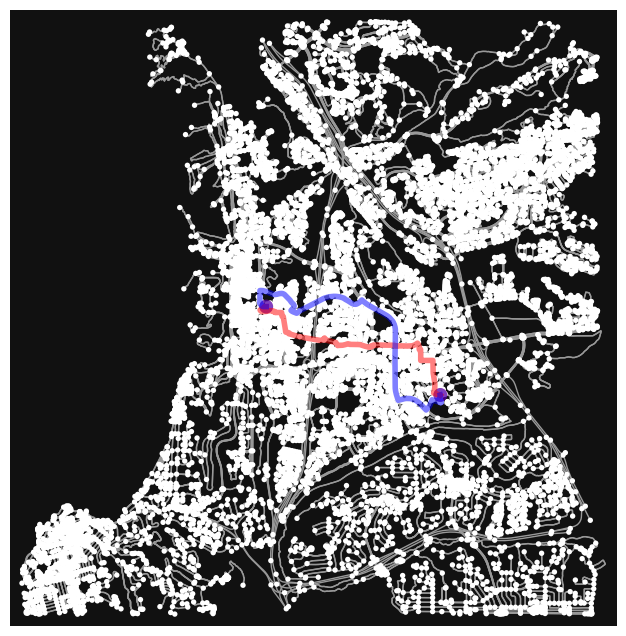

Combined-Graph Legend: 
		 Red: 	Shortest distance 
		 Blue: 	Shortest travel time


In [11]:
# Lets do our shortest_path now with the combined graphs - Intuitively it should match the driving graph.

full_starting_point = ox.distance.nearest_nodes(G_full, *ox.geocoder.geocode("Geisel Library")[::-1], return_dist=True)
full_end_point = ox.distance.nearest_nodes(G_full, *ox.geocoder.geocode("Chicago Fire & Grill")[::-1], return_dist=True)

# *note: with distance differences from the declared gps point.(*:? verify specifics.)
print("starting point (node id#): full:\t", full_starting_point)
print("end point (node id#): full:\t", full_end_point)

# Resolve shortest Path based on different weights:
full_route1 = ox.routing.shortest_path(G_full, full_starting_point[0], full_end_point[0], weight='length', cpus=1)
full_route2 = ox.routing.shortest_path(G_full, full_starting_point[0], full_end_point[0], weight='travel_time', cpus=1)

full_route_travel_time = nx.shortest_path_length(G_full, full_starting_point[0], full_end_point[0], weight='travel_time')
full_route_length = nx.shortest_path_length(G_full, full_starting_point[0], full_end_point[0], weight='length') 

# This calculate length function still important, because it allows both length/time per all routes:
full_shortest_distance = calc_length_time(G_full,full_route1)
full_shortest_time = calc_length_time(G_full,full_route2)

print("shortest route length: ", full_shortest_distance[0], " meters.")
print("shortest route travel time: ", full_shortest_distance[1], " seconds.")
print("fastest route length: ", full_shortest_time[0], " meters.")
print("fastest route time: ", full_shortest_time[1], " seconds.")

# Plot our combined route:
full_proposed_route = [full_route1, full_route2]
ox.plot.plot_graph_routes(G_full, full_proposed_route, route_colors=['r','b'], save=True, filepath="data/full_route_plot.png")
print("Combined-Graph Legend: \n\t\t Red: \tShortest distance \n\t\t Blue: \tShortest travel time")


#### What this tells us:

 Here we see more distinct paths for shortest time as well as shortest distance, however due to the immense oversimplification of simply merging graphs, there is some inherent assumptions being used within our calculations that would have to have carefully hand-crafted functions to overcome. Namely, what the proposed route here is telling us is that we can "hot-swap" our modality of travel at any given point in the graph at will and without consequence. 

 This means that the shortest-distance path is a makeup of interwoven drivable + walking paths, which is not only impractical in use/practice, but also not how we would want to think of this as a functional proposed route. Ultimately, the raw merged graph-layers as is makes this shortest-path-distance a valid metric, though functionally and practically unusable without modifications.
 
 Though the shortest-travel time path may be a valid path only by consequence of driving speeds being exceptionally faster for most points, the logical gap to shortcut these modalities is still present. 
 An interesting followup observation here is that this is still slightly different in route and duration than presented by the pure graphs - this is assumed to be due to proximity of the start and endpoints being different per independent graph. 
 With the increased node density of the walking graph, it is more likely to pick a walking-graph starting point and end point node, which would be included to walk to the nearest driving graph node (which may itself be a different node than the independent graphs' starting and endpoints due to proximity calculations.) 
 As a secondary observation here, the shape of the route is not entirely the same, so further deep analysis of the route itself is warrented to see if there are unintended shortcuts in the merged datapoints that perhaps have missed labels or speed associations between the newly merged graphs. A likely answer is that the speed for walking-driving paths may be inferred to be defaulted to driving speeds, similar to the issue we had to address in the walking independent graphs, and must be further processed (strategically) after merging.

Further improvements: If these merged graphs were to be further optimized to be usable to a user w/ a direct map API, these issues would all need to be addressed (taking some time in hard-coding functions and algorithms to micromanage the results as needed). 
A properly implemented merged graph would need to apply rules following either 'pick-up' or 'parking', neither of which currently supported in given graph labels at this point.

 Tracking parking would require locating parking-available spots would be its own' independent graph layer to be merged, where only at parking spots could modalities switch between driving and walking, and only functionably usable at the starting/endpoints of a travel route. These functions would depend heavily on the use-case of the map service (a phone service API vs a taxi service application), so how they are hardcoded changes heavily dependent on the use-case. 


 Applying our metrics over the merged layers of these graph types shows that it works somewhat seemlessly when the data matches up well, however highlights the importance of tracking the contextual discrepencies brought by the different layers when applying our target application. 
 
 We did not have much time to dive too much into the limiting details further here, as this is a prototyped project.